Importing Libraries

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
%matplotlib inline

Importing and Cleaning data

In [42]:
df = pd.read_csv("mlb_payroll_1.csv")
display(df)
display(df.columns)

,Year,Team,Record,Avg AgeTeam,Total PayrollAllocations,Active26-Man,Injured,Retained,Buried,Playoffs,Champs
0,2025,LAD,93-69,29.5,"$350,024,106","$268,807,958","$48,883,969",-,"$1,753,867",1,1
1,2025,NYM,83-79,29.3,"$342,303,011","$268,004,963","$48,538,020",-,"$19,353,633",0,0
2,2025,PHI,96-66,30.4,"$293,240,191","$226,763,871","$55,474,994","$3,000,000","$2,359,921",1,0
3,2025,NYY,94-68,29.7,"$304,091,683","$198,430,719","$46,660,521","$5,000,000","$2,827,701",1,0
4,2025,CHC,92-70,29.6,"$214,020,073","$177,899,985","$11,051,639","$2,750,000","$4,108,173",1,0
...,...,...,...,...,...,...,...,...,...,...,...
445,2011,CLE,80-82,27.3,"$55,544,993","$55,544,993",-,-,-,0,0
446,2011,SD,71-91,27.9,"$48,018,810","$47,418,810",-,"$600,000",-,0,0
447,2011,TB,91-71,27.7,"$45,386,925","$45,386,925",-,-,-,1,0
448,2011,PIT,72-90,26.9,"$47,140,145","$45,332,085",-,-,-,0,0


Index(['Year', 'Team', 'Record', 'Avg AgeTeam', 'Total PayrollAllocations',
       'Active26-Man', 'Injured', 'Retained', 'Buried', 'Playoffs', 'Champs'],
      dtype='object')

In [43]:
df = df.rename(columns={
    "Year": "year",
    "Team": "team",
    "Record": "record",
    "Avg AgeTeam": "avg_age",
    "Total PayrollAllocations": "total_payroll",
    "Active26-Man": "active_payroll",
    "Injured": "injured",
    "Retained": "retained",
    "Buried": "buried",
    "Playoffs": "playoffs",
    "Champs": "champs"
})

In [44]:
money_cols = ["total_payroll", "active_payroll", "injured", "retained", "buried"]

for col in money_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True)

In [45]:
df["wins"] = df["record"].str.split("-").str[0].astype(int)
df["losses"] = df["record"].str.split("-").str[1].astype(int)

In [46]:
cols = list(df.columns)

record_index = cols.index("record")

cols.remove("record")

cols.insert(record_index, "wins")
cols.insert(record_index + 1, "losses")

df = df[df['year'] != 2020]

df = df[cols]

df = df.iloc[:, :-2]

Creating "Momentum" stat

In [47]:
# Load game logs
logs = pd.read_csv("game_logs_raw.csv")

# Sort to ensure last games are at the bottom
logs = logs.sort_values(["team", "year"]).reset_index(drop=True)

# Keep last 30 games per team per year
last_30 = logs.groupby(["team", "year"]).tail(30).reset_index(drop=True)

#display(last_30)

# --- Step 1: Create win indicator and run differential ---
last_30["win"] = last_30["W/L"].map({"W": 1, "L": 0})
last_30["run_diff"] = last_30["R"] - last_30["RA"]

# --- Step 2: Last-30 Win Percentage ---
winpct_last30 = (
    last_30.groupby(["team", "year"])["win"]
           .mean()
           .rename("last30_winpct")
           .reset_index()
)

# --- Step 3: Last-30 Total Run Differential ---
rundiff_last30 = (
    last_30.groupby(["team", "year"])["run_diff"]
           .sum()
           .rename("last30_run_diff")
           .reset_index()
)

# --- Step 4: End-of-Season Streak (last streak value in the last 30 rows) ---
streak_last30 = (
    last_30.sort_values(["team", "year"])
           .groupby(["team", "year"])["Streak"]
           .last()
           .rename("end_season_streak")
           .reset_index()
)

# --- Step 5: Combine everything into one momentum table ---
momentum = (
    winpct_last30
    .merge(rundiff_last30, on=["team", "year"])
    .merge(streak_last30, on=["team", "year"])
)

#momentum

# --- Merge the payroll data with the momentum metrics ---
final_df = df.merge(momentum, on=["team", "year"], how="left")

# View the merged dataset
#6final_df.head()

# Create a normalized run differential (optional)
final_df["rd_norm"] = final_df["last30_run_diff"] / 30

# Create a normalized streak (0–1 scale)
final_df["streak_norm"] = final_df["end_season_streak"] / 10

# Create the momentum score
momentum_score = (
    0.5 * final_df["last30_winpct"] +
    0.4 * final_df["rd_norm"] +
    0.1 * final_df["streak_norm"]
)

# Add momentum as the last column
final_df["momentum"] = momentum_score

df = final_df

display(df)

,year,team,wins,losses,avg_age,total_payroll,active_payroll,injured,retained,buried,playoffs,champs,last30_winpct,last30_run_diff,end_season_streak,rd_norm,streak_norm,momentum
0,2025,LAD,93,69,29.5,350024106,268807958,48883969,-,1753867,1,1,0.680000,41.0,5.0,1.366667,0.5,0.936667
1,2025,NYM,83,79,29.3,342303011,268004963,48538020,-,19353633,0,0,0.379310,-7.0,-1.0,-0.233333,-0.1,0.086322
2,2025,PHI,96,66,30.4,293240191,226763871,55474994,3000000,2359921,1,0,0.642857,40.0,1.0,1.333333,0.1,0.864762
3,2025,NYY,94,68,29.7,304091683,198430719,46660521,5000000,2827701,1,0,0.724138,54.0,8.0,1.800000,0.8,1.162069
4,2025,CHC,92,70,29.6,214020073,177899985,11051639,2750000,4108173,1,0,0.555556,21.0,3.0,0.700000,0.3,0.587778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,2011,CLE,80,82,27.3,55544993,55544993,-,-,-,0,0,0.407407,-44.0,-4.0,-1.466667,-0.4,-0.422963
416,2011,SD,71,91,27.9,48018810,47418810,-,600000,-,0,0,0.392857,-18.0,1.0,-0.600000,0.1,-0.033571
417,2011,TB,91,71,27.7,45386925,45386925,-,-,-,1,0,0.555556,26.0,5.0,0.866667,0.5,0.674444
418,2011,PIT,72,90,26.9,47140145,45332085,-,-,-,0,0,0.310345,-58.0,-2.0,-1.933333,-0.2,-0.638161


Initial Visuals showcasing just payroll and success by year for every team

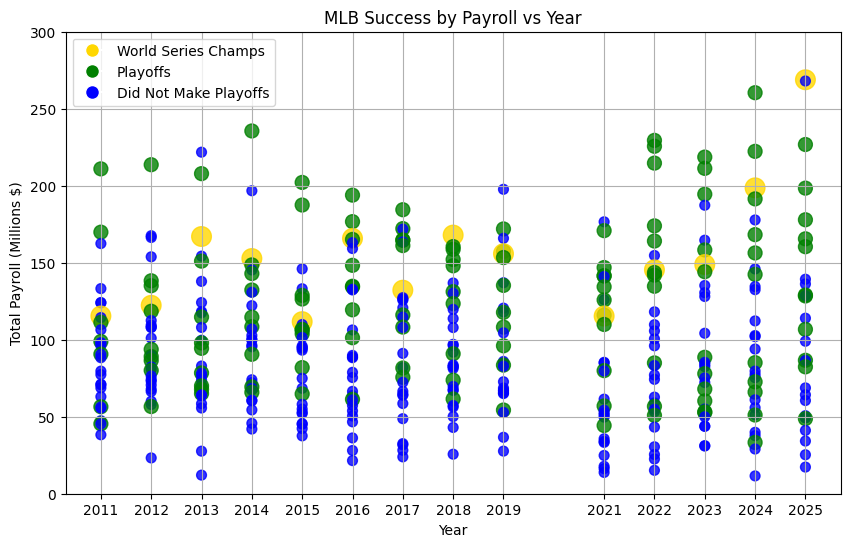

In [48]:
# Ensure total_payroll is numeric
df['active_payroll'] = pd.to_numeric(df['active_payroll'], errors='coerce')

# Create color and size lists
colors = []
sizes = []

for _, row in df.iterrows():
    if row['champs'] == 1:
        colors.append('gold')      # World Series champions
        sizes.append(200)          # Big size
    elif row['playoffs'] == 1:
        colors.append('green')     # Made playoffs
        sizes.append(100)          # Medium size
    else:
        colors.append('blue')      # Did not make playoffs
        sizes.append(50)           # Small size

plt.figure(figsize=(10,6))
plt.scatter(df['year'], df['active_payroll'] / 1_000_000, color=colors, s=sizes, alpha=0.8)

# X-axis: integer years only
plt.xticks(df['year'].unique())

# Y-axis: 0 to 300 million → 0 to 300 in millions, ticks every 50
plt.ylim(0, 300)
plt.yticks(np.arange(0, 301, 50))

plt.title("MLB Success by Payroll vs Year")
plt.xlabel("Year")
plt.ylabel("Total Payroll (Millions $)")
plt.grid(True)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='World Series Champs', markerfacecolor='gold', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Playoffs', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Did Not Make Playoffs', markerfacecolor='blue', markersize=10)
]
plt.legend(handles=legend_elements)

plt.show()

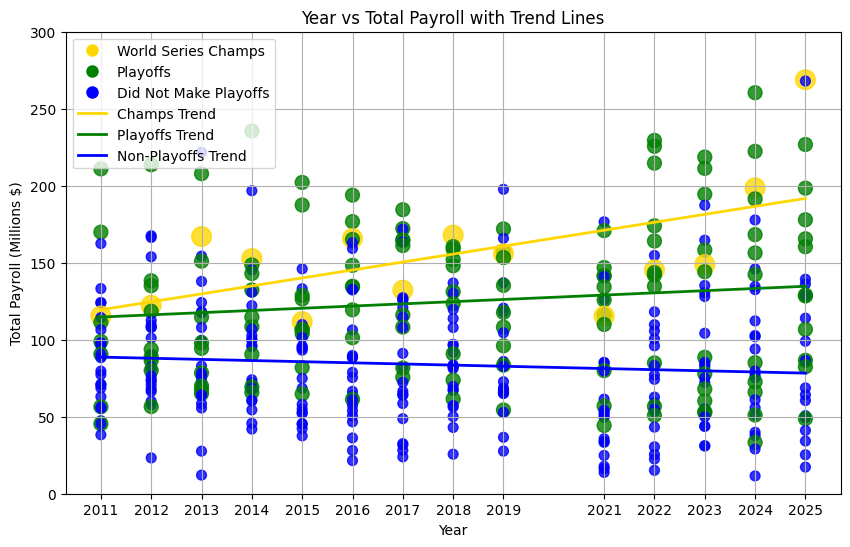

In [49]:
# Ensure total_payroll is numeric
df['active_payroll'] = pd.to_numeric(df['active_payroll'], errors='coerce')

# Separate the groups
champs = df[df['champs'] == 1]
playoffs = df[(df['playoffs'] == 1) & (df['champs'] == 0)]
non_playoffs = df[df['playoffs'] == 0]

plt.figure(figsize=(10,6))

# Function to plot linear trend line
def plot_trend_line(group_df, color, label):
    if len(group_df) > 1:  # Need at least 2 points to fit a line
        z = np.polyfit(group_df['year'], group_df['active_payroll']/1_000_000, 1)  # Linear fit
        p = np.poly1d(z)
        plt.plot(np.sort(group_df['year']), p(np.sort(group_df['year'])), color=color, linewidth=2, label=label)

# Plot trend lines
plot_trend_line(champs, 'gold', 'Champs Trend')
plot_trend_line(playoffs, 'green', 'Playoffs Trend')
plot_trend_line(non_playoffs, 'blue', 'Non-Playoffs Trend')

# Scatter points with sizes
sizes = []
colors = []
for _, row in df.iterrows():
    if row['champs'] == 1:
        colors.append('gold')
        sizes.append(200)
    elif row['playoffs'] == 1:
        colors.append('green')
        sizes.append(100)
    else:
        colors.append('blue')
        sizes.append(50)

plt.scatter(df['year'], df['active_payroll']/1_000_000, color=colors, s=sizes, alpha=0.8)

# X-axis: integer years only
plt.xticks(df['year'].unique())

# Y-axis: 0 to 300 in millions
plt.ylim(0, 300)
plt.yticks(np.arange(0, 301, 50))

plt.title("Year vs Total Payroll with Trend Lines")
plt.xlabel("Year")
plt.ylabel("Total Payroll (Millions $)")
plt.grid(True)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='World Series Champs', markerfacecolor='gold', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Playoffs', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Did Not Make Playoffs', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], color='gold', lw=2, label='Champs Trend'),
    Line2D([0], [0], color='green', lw=2, label='Playoffs Trend'),
    Line2D([0], [0], color='blue', lw=2, label='Non-Playoffs Trend')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.show()

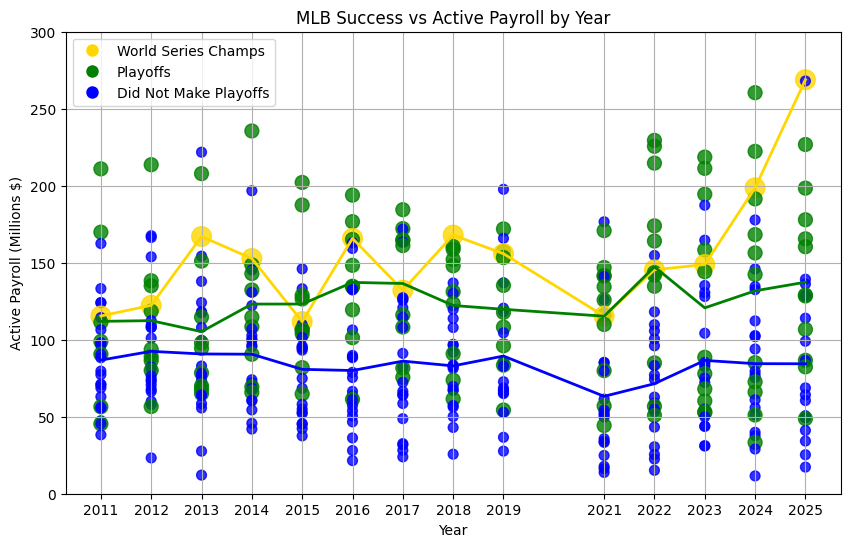

In [50]:

# Ensure total_payroll is numeric
df['active_payroll'] = pd.to_numeric(df['active_payroll'], errors='coerce')

# Define groups
groups = {
    'Champs': df[df['champs'] == 1],
    'Playoffs': df[(df['playoffs'] == 1) & (df['champs'] == 0)],
    'Non-Playoffs': df[df['playoffs'] == 0]
}

# Colors and sizes
group_colors = {'Champs':'gold', 'Playoffs':'green', 'Non-Playoffs':'blue'}
group_sizes = {'Champs':200, 'Playoffs':100, 'Non-Playoffs':50}

plt.figure(figsize=(10,6))

# Plot scatter points
colors = []
sizes = []
for _, row in df.iterrows():
    if row['champs'] == 1:
        colors.append('gold')
        sizes.append(200)
    elif row['playoffs'] == 1:
        colors.append('green')
        sizes.append(100)
    else:
        colors.append('blue')
        sizes.append(50)

plt.scatter(df['year'], df['active_payroll']/1_000_000, color=colors, s=sizes, alpha=0.8)

# Plot trend lines: average per year per group
for group_name, group_df in groups.items():
    avg_per_year = group_df.groupby('year')['active_payroll'].mean().reset_index()
    plt.plot(avg_per_year['year'], avg_per_year['active_payroll']/1_000_000,
             color=group_colors[group_name], linewidth=2, label=f'{group_name} Trend')

# X-axis: integer years only
plt.xticks(df['year'].unique())

# Y-axis: 0 to 350 in millions, ticks every 50
plt.ylim(0, 300)
plt.yticks(np.arange(0, 301, 50))

plt.title("MLB Success vs Active Payroll by Year")
plt.xlabel("Year")
plt.ylabel("Active Payroll (Millions $)")
plt.grid(True)

# Legend for points and trend lines
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='World Series Champs', markerfacecolor='gold', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Playoffs', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Did Not Make Playoffs', markerfacecolor='blue', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper left')

plt.show()

Visualizing momentum

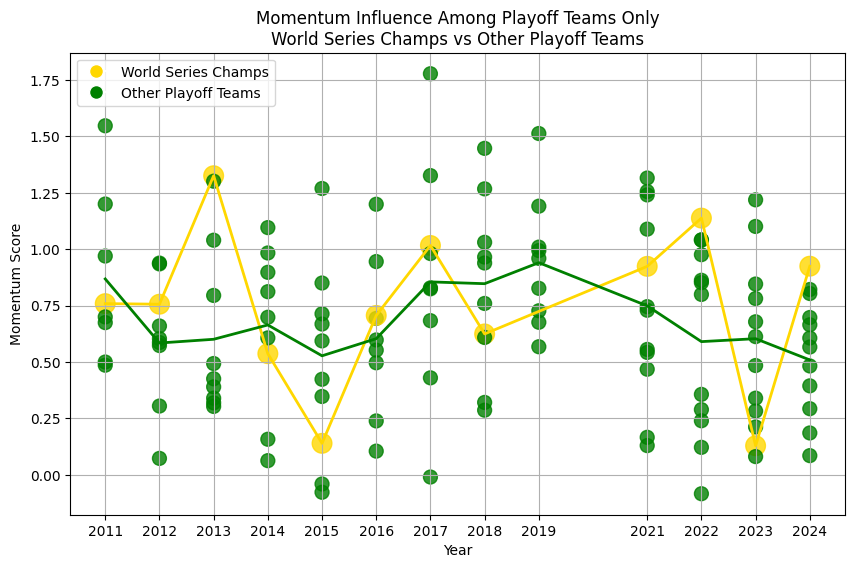

In [51]:

# Remove rows where momentum is missing
df_clean = df.dropna(subset=['momentum'])

# Filter to playoff teams only
playoff_df = df_clean[df_clean['playoffs'] == 1]

# Remove 2025 if needed (like your original plot)
playoff_df = playoff_df[playoff_df['year'] != 2025]

# Define groups (only playoff teams now)
groups = {
    'Champs': playoff_df[playoff_df['champs'] == 1],
    'Playoffs': playoff_df[playoff_df['champs'] == 0]
}

# Colors and sizes for just 2 groups
group_colors = {'Champs': 'gold', 'Playoffs': 'green'}
group_sizes = {'Champs': 200, 'Playoffs': 100}

plt.figure(figsize=(10,6))

# Plot scatter points ONLY for playoff teams
colors = []
sizes = []
for _, row in playoff_df.iterrows():
    if row['champs'] == 1:
        colors.append('gold')
        sizes.append(200)
    else:
        colors.append('green')
        sizes.append(100)

plt.scatter(
    playoff_df['year'],
    playoff_df['momentum'],
    color=colors,
    s=sizes,
    alpha=0.8
)

# Trend lines: average momentum per year per group
for group_name, group_df in groups.items():
    avg_per_year = (
        group_df
        .groupby('year')['momentum']
        .mean()
        .reset_index()
    )

    plt.plot(
        avg_per_year['year'],
        avg_per_year['momentum'],
        color=group_colors[group_name],
        linewidth=2,
        label=f'{group_name} Trend'
    )

# X-axis: unique years
plt.xticks(sorted(playoff_df['year'].unique()))

plt.title("Momentum Influence Among Playoff Teams Only\nWorld Series Champs vs Other Playoff Teams")
plt.xlabel("Year")
plt.ylabel("Momentum Score")
plt.grid(True)

# Legend for scatter points
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='World Series Champs',
           markerfacecolor='gold', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Other Playoff Teams',
           markerfacecolor='green', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper left')

plt.show()


Logistic regression showcasing the significance payroll has on making the playoffs

In [52]:
from sklearn.linear_model import LogisticRegression

X = (df["active_payroll"] / 1_000_000).values.reshape(-1, 1)
y = df["playoffs"].values  # 1 = made playoffs, 0 = did not

model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

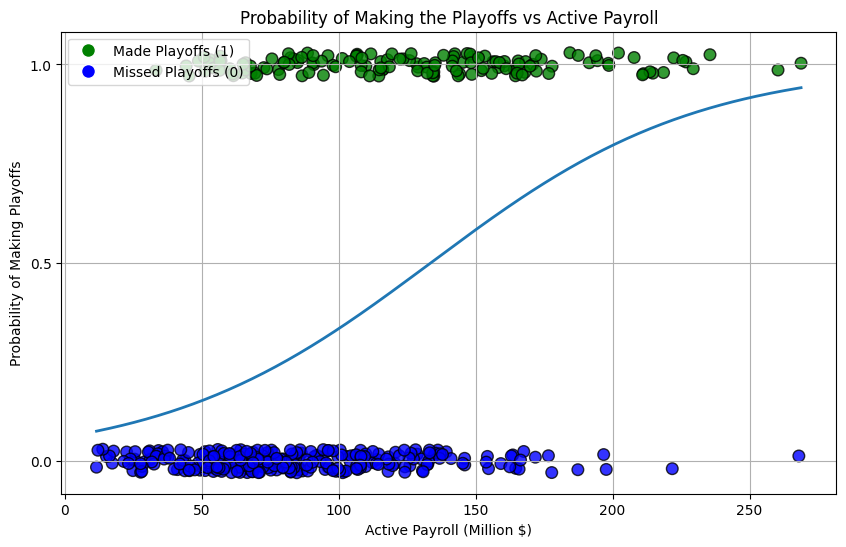

In [53]:
# Smooth curve range
X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_pred = model.predict_proba(X_plot)[:, 1]

plt.figure(figsize=(10,6))

# ----- Jitter binary outcomes -----
jitter = np.random.uniform(-0.03, 0.03, size=len(y))
y_jittered = y + jitter

# ----- Colors -----
colors = np.where(y == 1, "green", "blue")

plt.scatter(X.flatten(), y_jittered, 
            c=colors, s=70, alpha=0.8, edgecolor="black")

# ----- Logistic regression curve -----
plt.plot(X_plot.flatten(), y_pred, linewidth=2)

plt.title("Probability of Making the Playoffs vs Active Payroll")
plt.xlabel("Active Payroll (Million $)")
plt.ylabel("Probability of Making Playoffs")
plt.yticks([0, 0.5, 1])
plt.grid(True)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Made Playoffs (1)', 
           markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Missed Playoffs (0)', 
           markerfacecolor='blue', markersize=10)
]
plt.legend(handles=legend_elements, loc="upper left")

plt.show()

In [54]:
import statsmodels.api as sm
import numpy as np

# Feature (scaled to millions)
X = df["active_payroll"] / 1_000_000
X = sm.add_constant(X)  # add intercept

# Target
y = df["playoffs"]

# Fit model
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.553412
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               playoffs   No. Observations:                  420
Model:                          Logit   Df Residuals:                      418
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Nov 2025   Pseudo R-squ.:                  0.1472
Time:                        14:33:36   Log-Likelihood:                -232.43
converged:                       True   LL-Null:                       -272.54
Covariance Type:            nonrobust   LLR p-value:                 3.355e-19
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.7428      0.298     -9.201      0.000      -3.327      -2.159
active_payroll   

Analyzing the affect of payroll on winning the World Series once you make the playoffs

In [55]:
playoff_df = df[df['playoffs'] == 1]
playoff_df = playoff_df[playoff_df['year'] != 2025]

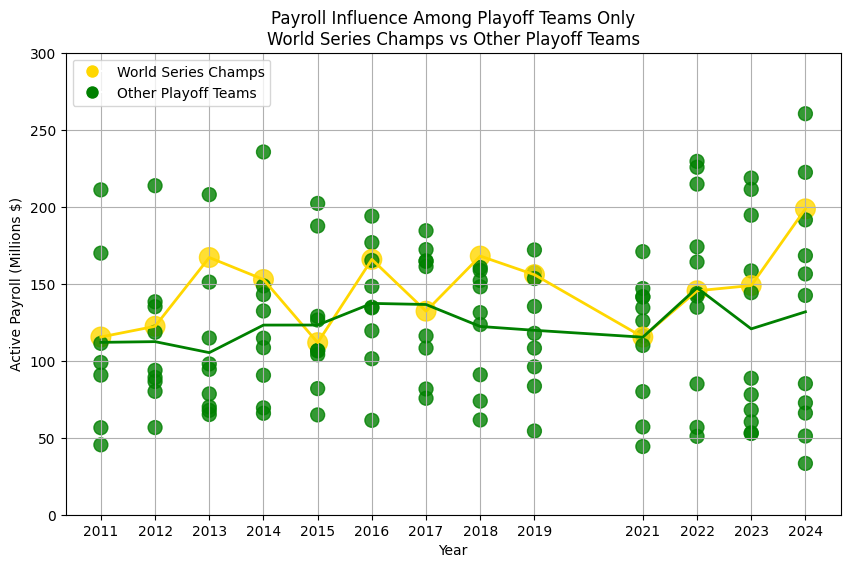

In [56]:
# Ensure payroll is numeric
df['active_payroll'] = pd.to_numeric(df['active_payroll'], errors='coerce')

# Remove rows with "-" or missing numeric values
df_clean = df.dropna(subset=['active_payroll'])

# Filter to playoff teams only
playoff_df = df_clean[df_clean['playoffs'] == 1]
playoff_df = playoff_df[playoff_df['year'] != 2025]

# Define groups (only playoff teams now)
groups = {
    'Champs': playoff_df[playoff_df['champs'] == 1],
    'Playoffs': playoff_df[playoff_df['champs'] == 0]
}

# Colors and sizes for just 2 groups
group_colors = {'Champs':'gold', 'Playoffs':'green'}
group_sizes = {'Champs':200, 'Playoffs':100}

plt.figure(figsize=(10,6))

# Plot scatter points ONLY for playoff teams
colors = []
sizes = []
for _, row in playoff_df.iterrows():
    if row['champs'] == 1:
        colors.append('gold')
        sizes.append(200)
    else:
        colors.append('green')
        sizes.append(100)

plt.scatter(
    playoff_df['year'],
    playoff_df['active_payroll'] / 1_000_000,
    color=colors,
    s=sizes,
    alpha=0.8
)

# Trend lines: average per year per group
for group_name, group_df in groups.items():
    avg_per_year = (
        group_df
        .groupby('year')['active_payroll']
        .mean()
        .reset_index()
    )

    plt.plot(
        avg_per_year['year'],
        avg_per_year['active_payroll'] / 1_000_000,
        color=group_colors[group_name],
        linewidth=2,
        label=f'{group_name} Trend'
    )

# X-axis: unique years
plt.xticks(sorted(playoff_df['year'].unique()))

# Y-axis formatting
plt.ylim(0, 300)
plt.yticks(np.arange(0, 301, 50))

plt.title("Payroll Influence Among Playoff Teams Only\nWorld Series Champs vs Other Playoff Teams")
plt.xlabel("Year")
plt.ylabel("Active Payroll (Millions $)")
plt.grid(True)

# Legend for scatter points
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='World Series Champs',
           markerfacecolor='gold', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Other Playoff Teams',
           markerfacecolor='green', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper left')

plt.show()

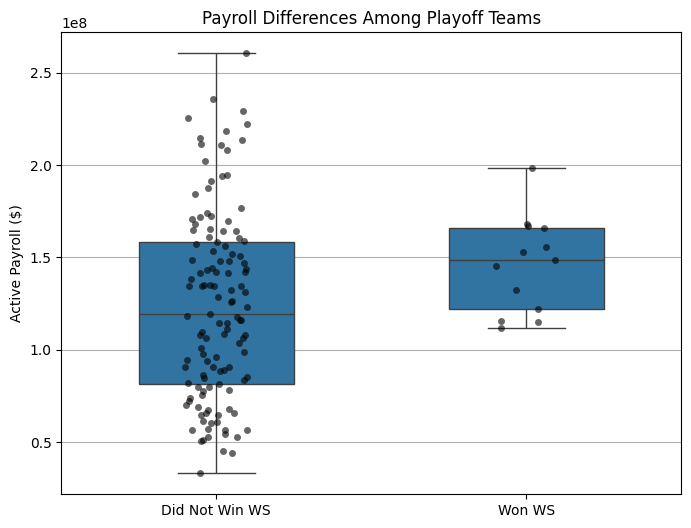

In [57]:
# Clean numeric
df['active_payroll'] = pd.to_numeric(df['active_payroll'], errors='coerce')

# Filter to playoff teams only
playoff_df = df[df['playoffs'] == 1].dropna(subset=['active_payroll'])
playoff_df = playoff_df[playoff_df['year'] != 2025]

plt.figure(figsize=(8,6))

sns.boxplot(
    data=playoff_df,
    x='champs',
    y='active_payroll',
    width=0.5
)

sns.stripplot(
    data=playoff_df,
    x='champs',
    y='active_payroll',
    jitter=True,
    alpha=0.6,
    color='black'
)

plt.xticks([0,1], ["Did Not Win WS", "Won WS"])
plt.ylabel("Active Payroll ($)")
plt.xlabel("")
plt.title("Payroll Differences Among Playoff Teams")
plt.grid(axis='y')

plt.show()

In [58]:
import statsmodels.api as sm

# playoff teams only
playoff_df = df[df['playoffs'] == 1].dropna(subset=['active_payroll'])
playoff_df = playoff_df[playoff_df['year'] != 2025]


X = playoff_df[['active_payroll']]
X = sm.add_constant(X)  # adds intercept
y = playoff_df['champs']

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.306844
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 champs   No. Observations:                  136
Model:                          Logit   Df Residuals:                      134
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Nov 2025   Pseudo R-squ.:                 0.02676
Time:                        14:33:37   Log-Likelihood:                -41.731
converged:                       True   LL-Null:                       -42.878
Covariance Type:            nonrobust   LLR p-value:                    0.1298
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.4422      0.893     -3.853      0.000      -5.193      -1.691
active_payroll  8

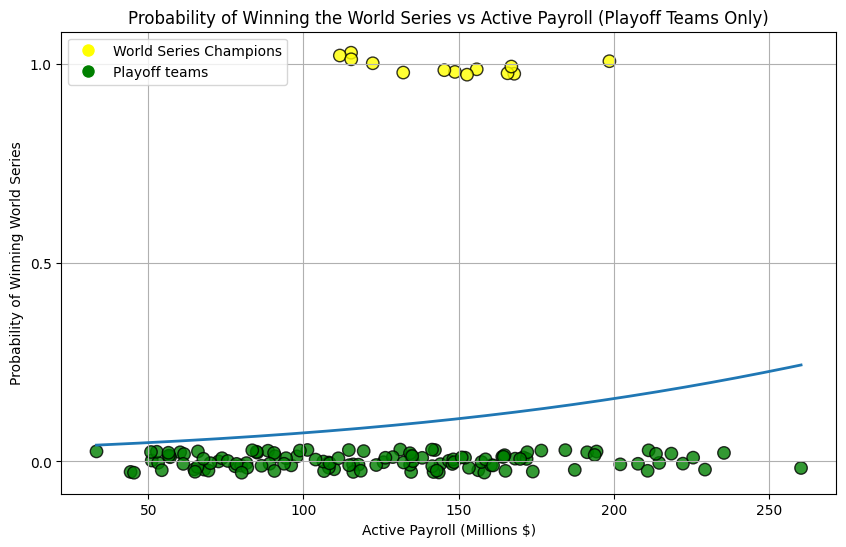

In [59]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

# Keep only playoff teams (0 or 1 result)
playoff_df = df[df["playoffs"] == 1].copy()
playoff_df = playoff_df[playoff_df['year'] != 2025]

# X = payroll (scale to millions for readability)
X = (playoff_df["active_payroll"] / 1_000_000).values.reshape(-1, 1)
y = playoff_df["champs"].values

# Fit logistic regression
model = LogisticRegression()
model.fit(X, y)

# Generate smooth curve
X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_pred = model.predict_proba(X_plot)[:, 1]

plt.figure(figsize=(10,6))

# ----- JITTER the binary outcomes -----
jitter = np.random.uniform(-0.03, 0.03, size=len(y))
y_jittered = y + jitter

# ----- COLOR by outcome -----
colors = np.where(y == 1, "yellow", "green")

plt.scatter(X.flatten(), y_jittered,
            c=colors, s=80, alpha=0.8, edgecolor="black")

# ----- Logistic regression curve -----
plt.plot(X_plot.flatten(), y_pred, linewidth=2)

# Formatting
plt.title("Probability of Winning the World Series vs Active Payroll (Playoff Teams Only)")
plt.xlabel("Active Payroll (Millions $)")
plt.ylabel("Probability of Winning World Series")

plt.yticks([0, 0.5, 1])
plt.grid(True)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='World Series Champions', 
           markerfacecolor='yellow', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Playoff teams', 
           markerfacecolor='green', markersize=10)
]
plt.legend(handles=legend_elements, loc="upper left")

plt.show()

Creating a supervised machine learning model for predicting team success with factors including payroll, injuries, and momentum

In [60]:
df = final_df[['avg_age', 'active_payroll', 'injured', 'playoffs', 'momentum']]
df = df[df['injured'] != '-']
df = df.dropna(subset=['momentum'])
display(df)

,avg_age,active_payroll,injured,playoffs,momentum
0,29.5,268807958,48883969,1,0.936667
1,29.3,268004963,48538020,0,0.086322
2,30.4,226763871,55474994,1,0.864762
3,29.7,198430719,46660521,1,1.162069
4,29.6,177899985,11051639,1,0.587778
...,...,...,...,...,...
342,28.3,97930597,4500000,1,0.493333
345,28.1,78454465,602603,1,1.039286
349,28.0,70361236,500625,0,-0.181111
351,29.1,70029393,270436,1,0.319259


<Axes: xlabel='injured'>

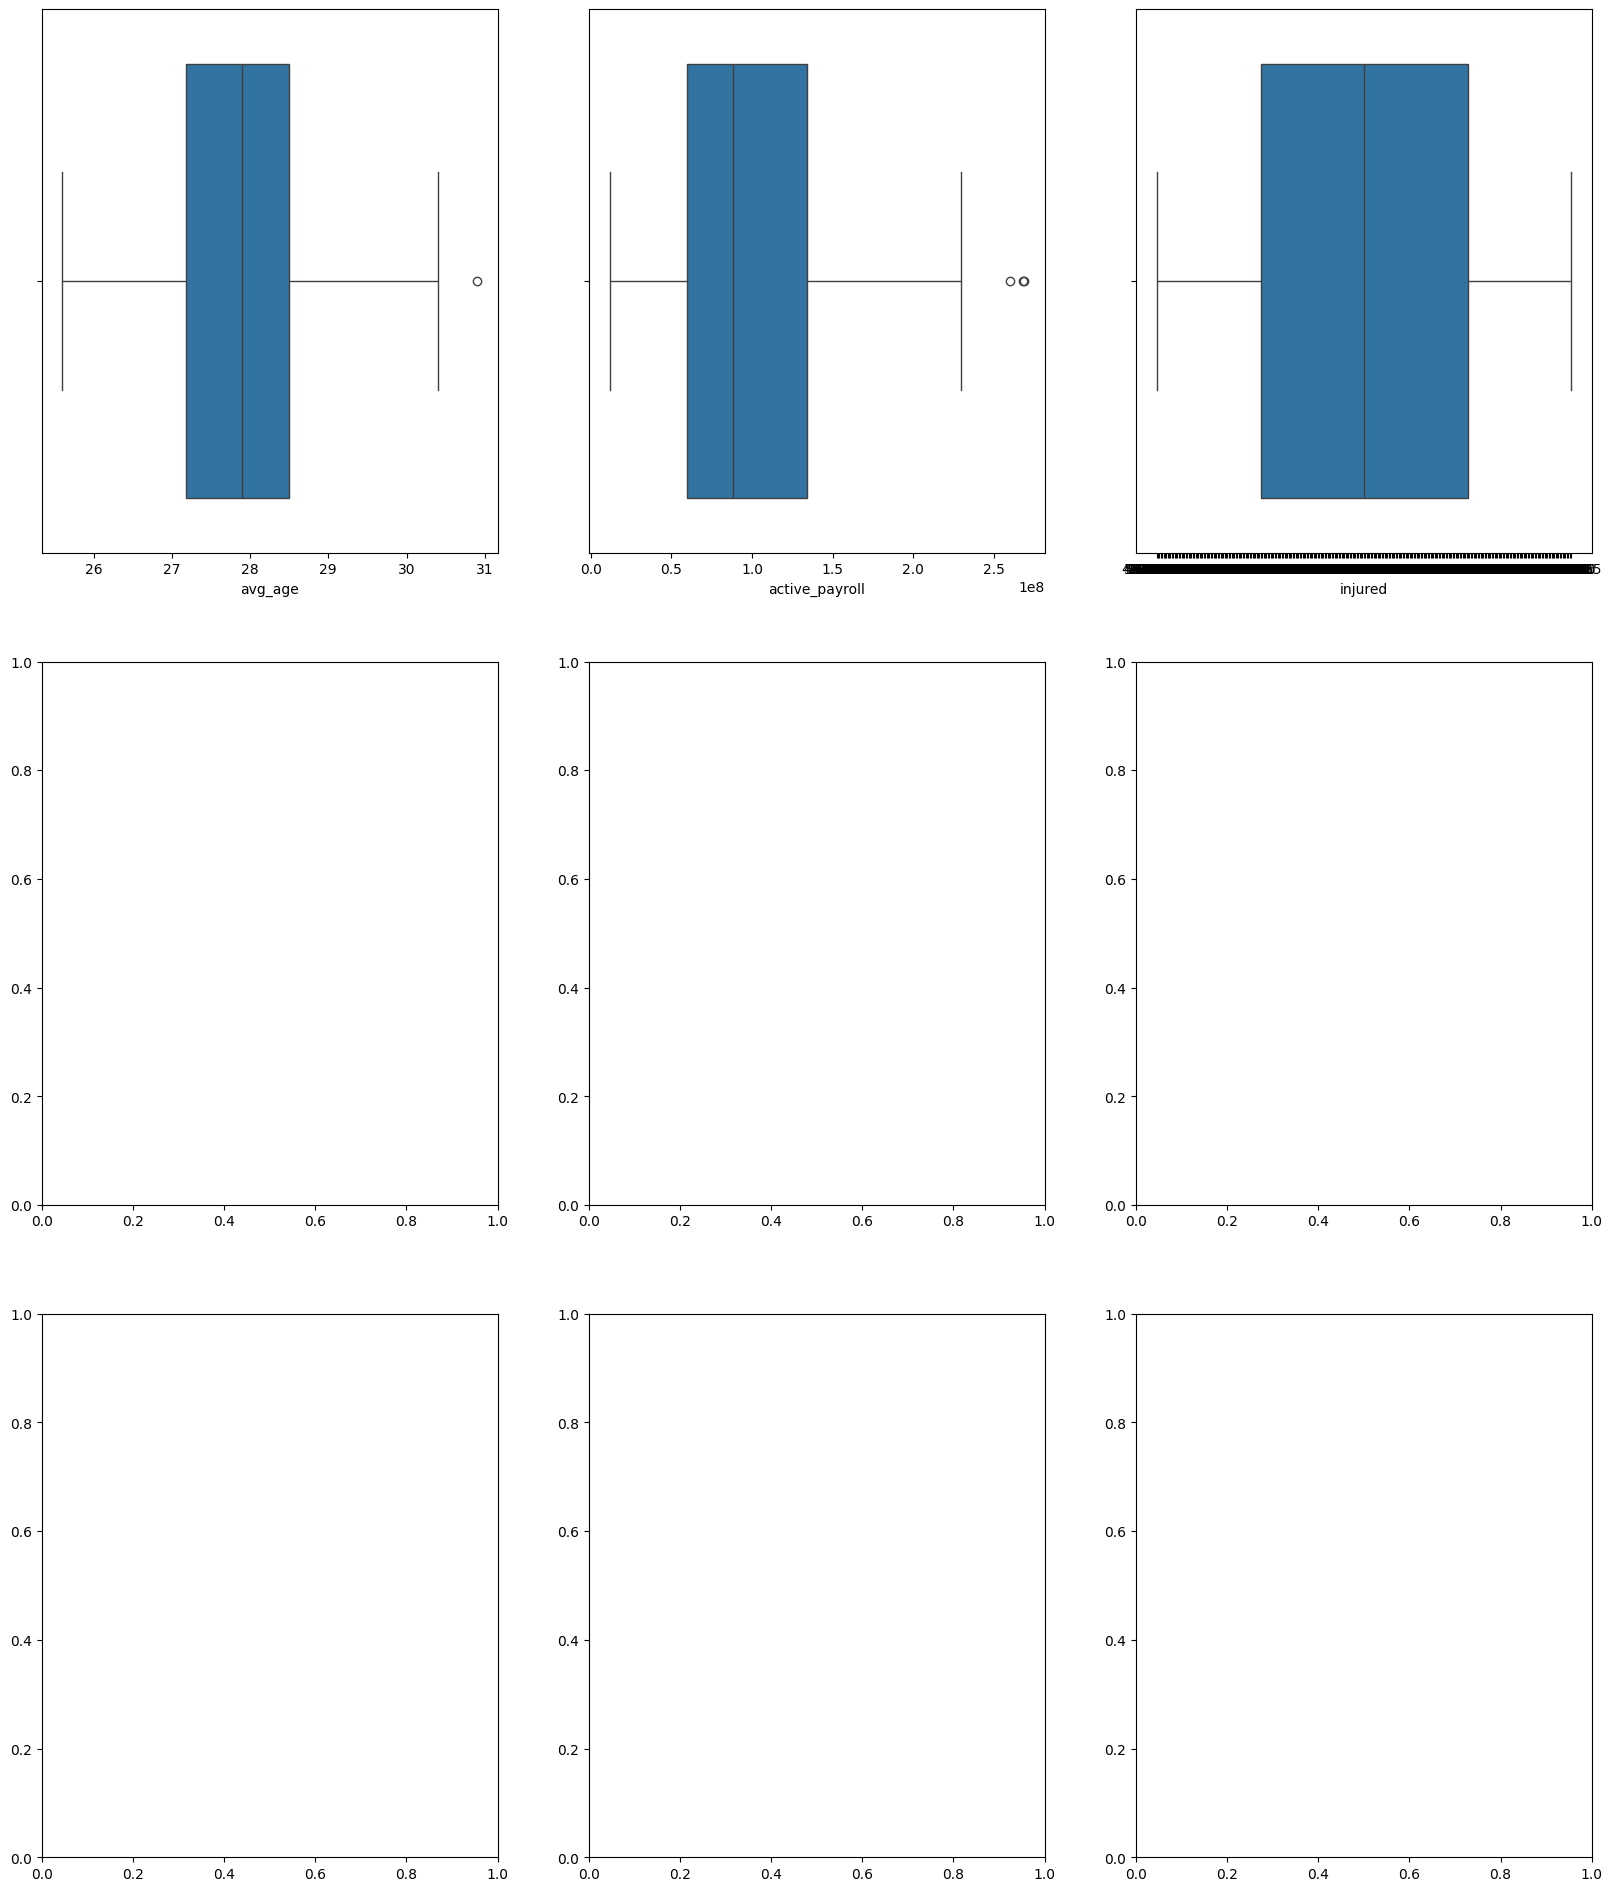

In [61]:
fig, axs = plt.subplots(3, 3, figsize=(20, 24))

sns.boxplot(x=df['avg_age'],          ax=axs[0,0])
sns.boxplot(x=df['active_payroll'],    ax=axs[0,1])
sns.boxplot(x=df['injured'],          ax=axs[0,2])

In [62]:
from sklearn.preprocessing import MinMaxScaler

sdf      = df.copy()
var      = list(sdf.columns)
var.remove("playoffs")
scaler   = MinMaxScaler()
sdf[var] = scaler.fit_transform(sdf[var])
display(sdf)

,avg_age,active_payroll,injured,playoffs,momentum
0,0.735849,1.000000,0.330105,1,0.710449
1,0.698113,0.996879,0.327756,0,0.417249
2,0.905660,0.836566,0.374861,1,0.685656
3,0.773585,0.726430,0.315007,1,0.788168
4,0.754717,0.646623,0.073209,1,0.590152
...,...,...,...,...,...
342,0.509434,0.335767,0.028720,1,0.557587
345,0.471698,0.260059,0.002256,1,0.745832
349,0.452830,0.228599,0.001563,0,0.325038
351,0.660377,0.227309,0.000000,1,0.497566


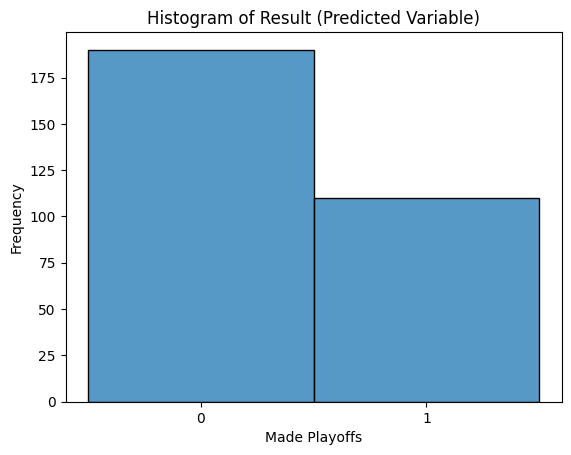

In [63]:
sns.histplot(df.playoffs, discrete=True)
plt.xticks([0, 1])
plt.xlabel('Made Playoffs')
plt.ylabel('Frequency')
plt.title(f'Histogram of Result (Predicted Variable)')

# Display the histogram
plt.show()

In [64]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
df_train, df_test = train_test_split(sdf, train_size = 0.7, test_size = 0.3, random_state = 100)
print('TRAINING DATA: ')
display(df_train)
print('TESTING DATA: ')
display(df_test)

TRAINING DATA: 


,avg_age,active_payroll,injured,playoffs,momentum
297,0.075472,0.130570,0.005134,0,0.391409
100,0.396226,0.414186,0.045547,0,0.492959
289,0.283019,0.246361,0.039611,0,0.455552
276,0.603774,0.389450,0.069350,1,0.435757
136,0.358491,0.193797,0.089859,0,0.492330
...,...,...,...,...,...
68,0.547170,0.480671,0.083193,0,0.565633
55,0.339623,0.110114,0.735737,0,0.250586
81,0.132075,0.168919,0.010965,0,0.366797
294,0.339623,0.160337,0.224217,0,0.369892


TESTING DATA: 


,avg_age,active_payroll,injured,playoffs,momentum
234,0.452830,0.182799,0.001878,0,0.609818
144,0.584906,0.087128,0.682484,0,0.377141
228,0.509434,0.272460,0.129756,1,0.725473
209,0.169811,0.054872,0.013196,0,0.681469
262,0.452830,0.191596,0.020572,0,0.284373
...,...,...,...,...,...
241,0.679245,0.641898,0.001471,1,0.593600
30,0.660377,0.967310,0.172207,1,0.553884
213,0.358491,0.595805,0.051588,1,0.844486
246,0.547170,0.531592,0.016160,1,0.577998


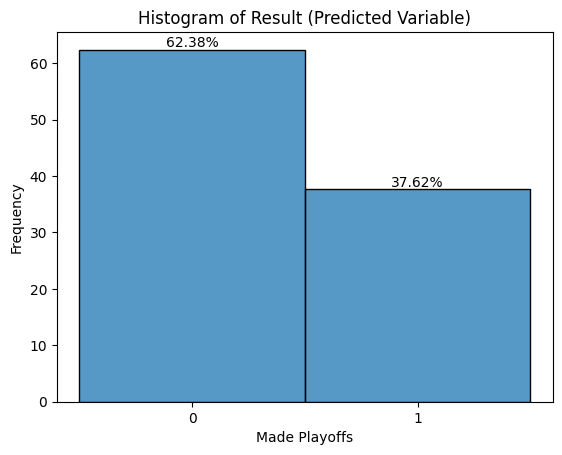

In [65]:
ax = sns.histplot(df_train.playoffs, discrete=True, stat='percent')
ax.bar_label(ax.containers[0], fmt='%.2f%%')
plt.xticks([0, 1])
plt.xlabel('Made Playoffs')
plt.ylabel('Frequency')
plt.title(f'Histogram of Result (Predicted Variable)')

# Display the histogram
plt.show()

In [66]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression()

In [67]:
y_train = df_train.pop('playoffs')
X_train = df_train

In [68]:
mod.fit(X_train, y_train)

LogisticRegression()

In [69]:
y_test = df_test.pop('playoffs')
X_test = df_test

In [70]:
y_predict = mod.predict(X_test)

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy  = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall    = recall_score(y_test, y_predict)
F1        = f1_score(y_test, y_predict)
print('ACCURACY:  ', accuracy)
print('PRECISION: ', precision)
print('RECALL:    ', recall)
print('F1:        ', F1)

ACCURACY:   0.8888888888888888
PRECISION:  0.8620689655172413
RECALL:     0.8064516129032258
F1:         0.8333333333333334


In [72]:
from sklearn.metrics import roc_auc_score

roc_auc_score = roc_auc_score(y_test, y_predict)
print('ROC_AUC_SCORE: ', roc_auc_score)

ROC_AUC_SCORE:  0.8693275013668671


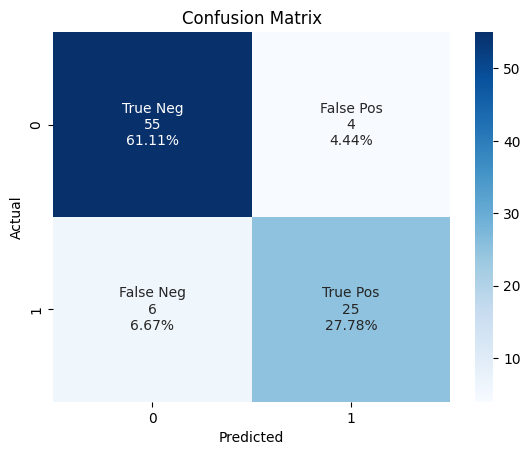

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion         = confusion_matrix(y_test, y_predict)
group_names       = ['True Neg','False Pos','False Neg','True Pos']
group_counts      = ['{0:0.0f}'.format(value) for value in confusion.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in confusion.flatten()/np.sum(confusion)]
labels            = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                     zip(group_names,group_counts,group_percentages)]
labels            = np.asarray(labels).reshape(2,2)

sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.8888888888888888
Precision: 0.8620689655172413
Recall: 0.8064516129032258
F1-score: 0.8333333333333334
Confusion Matrix:
 [[55  4]
 [ 6 25]]


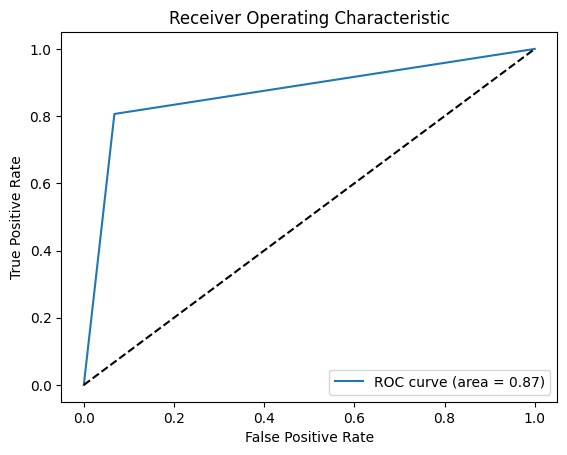

In [74]:
from sklearn.metrics import roc_curve

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {F1}")
print("Confusion Matrix:\n", confusion)

# For ROC Curve (assuming binary classification and y_prob are predicted probabilities)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        59
           1       0.86      0.81      0.83        31

    accuracy                           0.89        90
   macro avg       0.88      0.87      0.88        90
weighted avg       0.89      0.89      0.89        90



In [76]:
y_prob = mod.predict_proba(X_test)
print('TEST DATA IS OF LENGTH: ', len(y_prob))
print(y_prob)

TEST DATA IS OF LENGTH:  90
[[0.53534616 0.46465384]
 [0.83422068 0.16577932]
 [0.39186856 0.60813144]
 [0.6513966  0.3486034 ]
 [0.80879196 0.19120804]
 [0.84709192 0.15290808]
 [0.73683504 0.26316496]
 [0.1604153  0.8395847 ]
 [0.8549807  0.1450193 ]
 [0.37852714 0.62147286]
 [0.85996294 0.14003706]
 [0.53711859 0.46288141]
 [0.30384825 0.69615175]
 [0.91446507 0.08553493]
 [0.33392846 0.66607154]
 [0.70299288 0.29700712]
 [0.60970507 0.39029493]
 [0.698463   0.301537  ]
 [0.27151332 0.72848668]
 [0.7696929  0.2303071 ]
 [0.92328904 0.07671096]
 [0.81939394 0.18060606]
 [0.15312351 0.84687649]
 [0.40971027 0.59028973]
 [0.60642212 0.39357788]
 [0.74225714 0.25774286]
 [0.85788045 0.14211955]
 [0.72789876 0.27210124]
 [0.88435552 0.11564448]
 [0.60806355 0.39193645]
 [0.21484426 0.78515574]
 [0.9397246  0.0602754 ]
 [0.84593982 0.15406018]
 [0.65913958 0.34086042]
 [0.3309659  0.6690341 ]
 [0.87167827 0.12832173]
 [0.38096677 0.61903323]
 [0.80884861 0.19115139]
 [0.80193092 0.1980690

In [77]:
ulist = []
for i in range(len(y_prob)):
    if (y_prob[i,0] > .4) and (y_prob[i,0] < .6):
        ulist.append(i)

uindices = sorted((df_test.iloc[ulist]).index)
display(df.loc[df.index.isin(uindices)])

,avg_age,active_payroll,injured,playoffs,momentum
7,28.6,139280023,51185631,0,0.381190
10,29.5,128648209,68078413,0,0.335714
41,28.0,112213666,44602200,0,0.500238
71,28.4,104207606,81144181,0,0.632564
101,28.8,109766018,50192677,0,0.284713
106,27.9,83228504,44219852,0,0.600345
128,28.0,125829369,3193240,1,0.555714
162,28.1,104490573,16519542,0,0.871026
163,27.3,96059595,1773872,1,0.675952
183,28.8,152092957,37451220,1,0.321111


In [78]:
print(mod.coef_)

[[ 2.00451617  1.48721502 -0.9853941   3.97984742]]


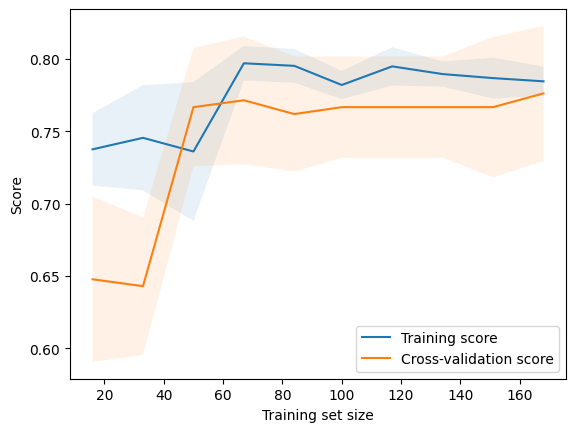

In [79]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(mod, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean                             = np.mean(train_scores, axis=1)
train_std                              = np.std(train_scores, axis=1)
test_mean                              = np.mean(test_scores, axis=1)
test_std                               = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend()
plt.show()

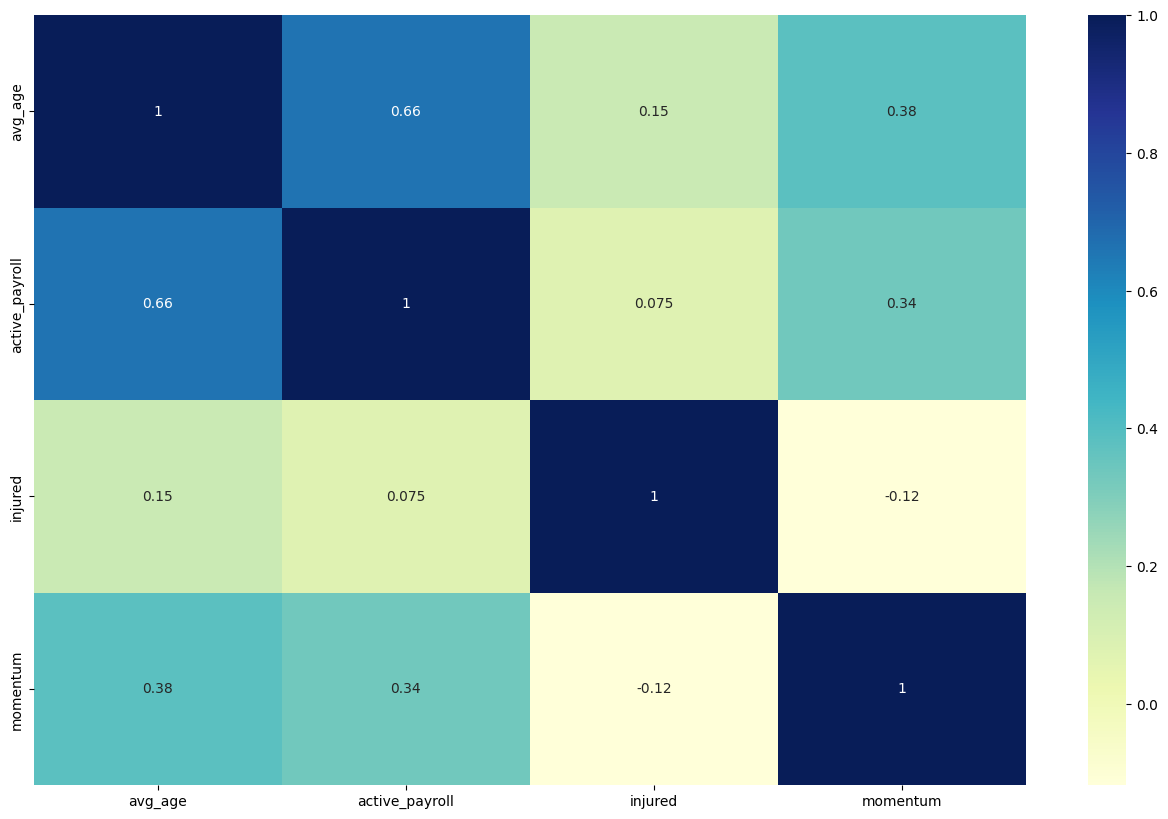

In [80]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

This is where I scraped baseball reference for the game logs of all the teams

In [119]:
import pandas as pd
from pybaseball import schedule_and_record
import numpy as np

# ---------------------------------------------
# 1. LOAD YOUR TEAM-YEAR DATASET
# ---------------------------------------------
df = pd.read_csv("mlb_payroll_1.csv")   # <-- change filename if needed

df['team'] = df['Team'].astype(str)
df['year'] = df['Year'].astype(int)

teams = df['team'].unique()
years = df['year'].unique()

print("Teams:", teams)
print("Years:", years)


# ---------------------------------------------
# 2. DOWNLOAD GAME LOGS FOR ALL TEAMS/YEARS
# ---------------------------------------------
game_logs = []

for y in years:
    for t in teams:
        try:
            print(f"Downloading {y} {t} ...")
            g = schedule_and_record(y, t)

            g['team'] = t
            g['year'] = y
            game_logs.append(g)

            print(f"SUCCESS: {y} {t}")

        except Exception as e:
            print(f"FAILED for {y} {t}: {e}")

# Combine all logs
games = pd.concat(game_logs, ignore_index=True)

# Convert date
games['Date'] = pd.to_datetime(games['Date'], errors='coerce')

print("\nDownloaded game logs shape:", games.shape)
print(games.head())

# ---------------------------------------------
# 3. SAVE RAW GAME LOGS
# ---------------------------------------------
games.to_csv("game_logs_raw.csv", index=False)

print("\nSaved: game_logs_raw.csv")

Teams: ['LAD' 'NYM' 'PHI' 'NYY' 'CHC' 'SD' 'TOR' 'HOU' 'SF' 'BOS' 'ATL' 'SEA'
 'TEX' 'DET' 'LAA' 'STL' 'MIL' 'KC' 'CIN' 'ARI' 'BAL' 'COL' 'PIT' 'MIN'
 'ATH' 'CLE' 'TB' 'MIA' 'WSH' 'CHW' 'OAK']
Years: [2025 2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012
 2011]
http://www.baseball-reference.com/teams/LAD/2025-schedule-scores.shtml


/scratch/00713/kelly/miniforge3/lib/python3.12/site-packages/pybaseball/team_results.py:75: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Attendance'].replace(r'^Unknown$', np.nan, regex=True, inplace = True) # make this a NaN so the column can benumeric


SUCCESS: 2025 LAD
http://www.baseball-reference.com/teams/NYM/2025-schedule-scores.shtml


KeyboardInterrupt: 